# Realtime monitor
## 0. Imports

In [1]:
#%matplotlib widget
import sqlite3, time, urllib.request
from datetime import datetime
from IPython.display import display, clear_output
import mplfinance as mpf
import pandas as pd
pd.set_option('display.max_columns', 0)

BASEURL = 'http://localhost:18080/kabusapi/'
BASEURL_TEST = 'http://localhost:18081/kabusapi/'

DB_PATH = 'D://data/kabustation_stock.db'

### functions

In [2]:
# freq = 1s, 1min, 5min, 1h, ...
def groupByTime(df, col, freq='1s'):
    df[col+'Time'] = pd.to_datetime(df[col+'Time'])
    df_sel = df.loc[:, [col+'Time', col]]
    df_gb = df_sel.groupby(pd.Grouper(key=col+'Time', freq=freq))
    return df_gb

def CreateStockData(df_ori, freq='1s'):
    df = df_ori.copy()
    df_gb = groupByTime(df, 'CurrentPrice', freq=freq)
    df_vol = groupByTime(df, 'TradingVolume', freq=freq).max()
    df_vol = df_vol.diff()
    df_stock = pd.concat([df_gb.first(), df_gb.max(), df_gb.min(), df_gb.last(), df_vol], axis=1)
    df_stock = df_stock.set_axis(['Open', 'High', 'Low', 'Close', 'Volume'], axis='columns')
    return df_stock

def mpfplot(data, **kwargs):
    style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={"font.family":'MS Gothic'})
    fig, ax = mpf.plot(data, figsize=(8, 6), style=style, returnfig=True, **kwargs)
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    return fig, ax

# when parse `ax`, must not parse figsize and returning=True
def mpfplotLive(data, **kwargs):
    style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={"font.family":'MS Gothic'})
    return mpf.plot(data, style=style, **kwargs)

## 1. Connect to DB

In [3]:
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

## 2. Realtime monitor today data using IPython.display

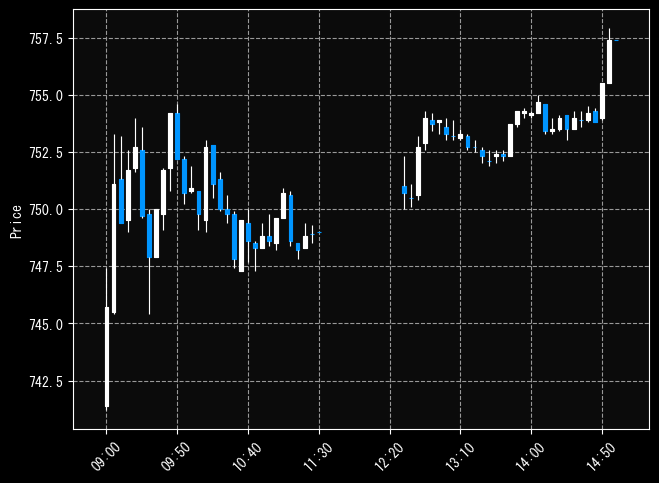

In [ ]:
today_date = datetime.date(datetime.now())
today_market_open_datetime_str = str(today_date) + ' 09:00:00'
is_first_data = True
last_data_datetime = ''
df_raw_keep = pd.DataFrame()

table_name = 'tick_4689_1'

interval_second = 300

while True:
    if is_first_data:
        df_raw = pd.read_sql(
            "SELECT * FROM %s WHERE CurrentPriceTime >= datetime('%s')"
            % (table_name, today_market_open_datetime_str), con)
        df_raw_keep = pd.concat([df_raw_keep, df_raw])
        df = CreateStockData(df_raw_keep, str(interval_second)+'s')
        fig, ax = mpfplot(df, type='candle')#, volume=True)
        #fig.canvas.draw()
        is_first_data = False
        
    else:
        df_raw = pd.read_sql(
            "SELECT * FROM %s WHERE CurrentPriceTime >= datetime('%s')"
            % (table_name, last_data_datetime), con)
        df_raw_keep = pd.concat([df_raw_keep, df_raw])
        df = CreateStockData(df_raw_keep, str(interval_second)+'s')
        ax[0].cla()
        mpfplotLive(df, type='candle', ax=ax[0])#, volume=ax[1])
        
    display(fig)        
    clear_output(wait = True)
    
    last_data_datetime = df_raw_keep.iloc[-1].CurrentPriceTime
    
    time.sleep(interval_second)

or Use widget

In [4]:
today_date = datetime.date(datetime.now())
today_market_open_datetime_str = str(today_date) + ' 09:00:00'
is_first_data = True
last_data_datetime = ''
df_raw_keep = pd.DataFrame()

table_name = 'tick_4689_1'

interval_second = 300

while True:
    if is_first_data:
        df_raw = pd.read_sql(
            "SELECT * FROM %s WHERE CurrentPriceTime >= datetime('%s')"
            % (table_name, today_market_open_datetime_str), con)
        df_raw_keep = pd.concat([df_raw_keep, df_raw])
        df = CreateStockData(df_raw_keep, str(interval_second)+'s')
        fig, ax = mpfplot(df, type='candle')#, volume=True)
        fig.canvas.draw()
        is_first_data = False
        
    else:
        df_raw = pd.read_sql(
            "SELECT * FROM %s WHERE CurrentPriceTime >= datetime('%s')"
            % (table_name, last_data_datetime), con)
        df_raw_keep = pd.concat([df_raw_keep, df_raw])
        df = CreateStockData(df_raw_keep, str(interval_second)+'s')
        ax[0].clear()
        mpfplotLive(df, type='candle', ax=ax[0])#, volume=ax[1])
        fig.canvas.draw()
        
    last_data_datetime = df_raw_keep.iloc[-1].CurrentPriceTime
    
    time.sleep(interval_second)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyboardInterrupt: 